In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import time
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

TensorFlow 1.x selected.


In [ ]:
class DCGAN(tf.keras.Model):
    def __init__(self, image_size, output_path, num_channels=1, z_dim=100,
                 G_h_size=128, D_h_size=128):

        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.multiply = int(np.log2(self.image_size / 8)) # столько раз нужно применить апсемплинг или даунсемплинг
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2) и наоборот
                                                
        self.output_path =  Path(output_path)
        (self.output_path / "model").mkdir(exist_ok=True)

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
         
        self.gen_loss_hist = []
        self.disc_loss_hist = []
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)
        self.start_iteration = 0

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):

        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):

        
        model = tf.keras.Sequential()
        # для начала сделаем вектор - трехмерным тензором м помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        # Превратим его в тензор размера (4, 4, self.G_h_size * 2**self.multiply)
        model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        
        for i in range(self.multiply):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 2**self.multiply // 2**(i+1))) # уменьшаем количество фильтров в два раза
        
        assert model.output_shape[1:] == (self.image_size // 2, self.image_size // 2, self.D_h_size), f"{model.output_shape, self.D_h_size}"
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        for i in range(self.multiply):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        assert model.output_shape[1:] == (4, 4, self.D_h_size * 2**self.multiply), f"{model.output_shape}"
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init, use_bias=False)) # без активации 
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):

        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"{epoch}.png")
        plt.show()
    
    def train(self, dataset, num_iters=2000, show_every=25):
        """
        Цикл обучения
        """
        start = time.time()
        iters = self.start_iteration
        for image_batch in dataset:
            print(".", end='')
            gen_loss, disc_loss = self.train_step(image_batch)
            
            self.disc_loss_hist.append(disc_loss.numpy())
            self.gen_loss_hist.append(gen_loss.numpy())    
            
            if iters % show_every == 0:
                display.clear_output(wait=True)
                plt.figure()
                plt.plot(self.disc_loss_hist, label="Discriminator loss")
                plt.plot(self.gen_loss_hist, label="Generator loss")
                plt.legend(loc="best")
                plt.figure()
                self.save_imgs(f"{iters}")
                self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
                
                print(f"\n{iters}/{num_iters}")
                print(f'Time elapsed from start {time.time() - start} sec')
                
            iters += 1
            if iters > num_iters:
                print(f'Finished. Time elapsed from start {time.time() - start} sec')
                return

## Загрузка датасета

In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:00, 110MB/s]  


## Задание 1. Создание генераторов данных

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 32

In [ ]:
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rescale=1./255)
image_generator = image_datagen.flow_from_directory(
         "/tmp/",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode=None)

Found 23708 images belonging to 5 classes.


Shape test passed


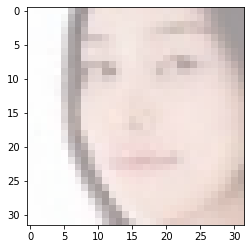

In [ ]:
sample = next(image_generator)
assert sample.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), f"Размер батча должен быть: {(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)}.  Получен {sample.shape}"
print("Shape test passed")
plt.imshow((sample[0] + 1.) / 2)

## Задание 2. Обучение DCGAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output = Path("/content/drive/MyDrive/gan_utk_32")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan = DCGAN(image_size=IMAGE_SIZE, num_channels=3, output_path=output, 
           z_dim=100, D_h_size=128, G_h_size=128)

In [ ]:
! pip install 'gast==0.2.2'

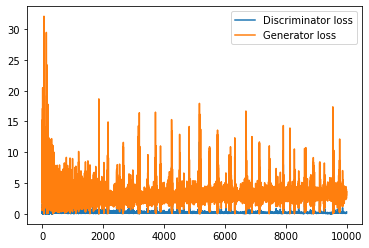

<Figure size 432x288 with 0 Axes>

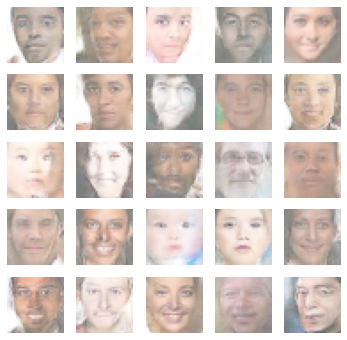


10000/10000
Time elapsed from start 2436.118355512619 sec
Finished. Time elapsed from start 2436.118414878845 sec


In [ ]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

Посмотрим какие лица научилась генерировать модель:

In [ ]:
def generate_data(latent_vector, generator):

    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [ 0.11665912  0.12431403 -0.7490987   0.49994272  0.8769106   0.31163293
 -1.9330555   1.4790493  -0.92631876 -0.2400209 ]


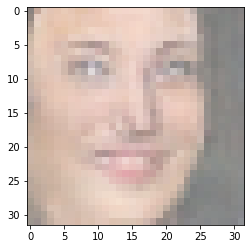

In [ ]:
v1 = tf.random.normal([1, 100]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0]) 

## Задание 3. Поиск вектора улыбки

In [ ]:
def generate_many(generator, n):
    vis_noise = np.random.normal(0, 1, (n, 100)).astype(np.float32)
    gen_imgs = generator(vis_noise, training=False)
    show_many(gen_imgs, "Generated images")
    return vis_noise

def show_many(images, title=""):
    w = h = int(np.sqrt(len(images)))
    images = (np.clip(images, -1, 1) + 1.) / 2. 
    
    fig, axs = plt.subplots(w, h, figsize=(w, h))
    if title != "":
        fig.suptitle(title)

    cnt = 0
    for i in range(h):
        for j in range(w):
            axs[i, j].imshow(images[cnt, :, :, :])
            axs[i, j].set_title(f"{cnt}")
            axs[i, j].axis('off')
            cnt += 1
    plt.subplots_adjust(wspace=.5) 

### a) Интерполяция

In [ ]:
def show_interpolation(v_1, v_2, generator, n=20):

    fig, axs = plt.subplots(1, n, figsize=(n,1))
    for i, alpha in enumerate(np.linspace(0, 1, n)):
        curr_vec = v_1 * (1-alpha) + v_2 * alpha
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')

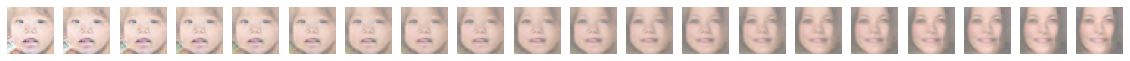

In [ ]:
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])

show_interpolation(v1, v2, gan.generator)

## b) Поиск вектора улыбки

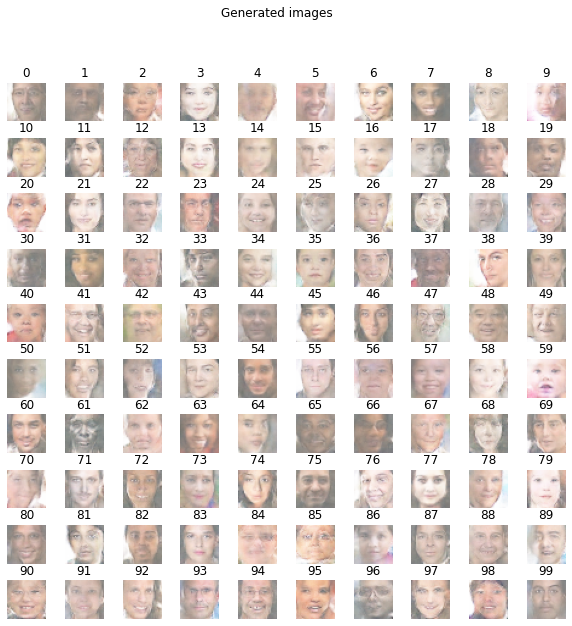

In [ ]:
faces = generate_many(gan.generator, 100)

In [ ]:
mean_smile = (np.asarray([faces[5]]) + np.asarray([faces[10]]) + np.asarray([faces[13]]) + np.asarray([faces[24]]) + np.asarray([faces[29]]) + np.asarray([faces[31]]) +
              np.asarray([faces[34]]) + np.asarray([faces[41]]) + np.asarray([faces[43]]) + np.asarray([faces[92]])/10.)

mean_neutral = (np.asarray([faces[2]]) + np.asarray([faces[9]]) + np.asarray([faces[14]]) + np.asarray([faces[18]]) + np.asarray([faces[23]]) + np.asarray([faces[35]]) +
              np.asarray([faces[38]]) + np.asarray([faces[55]]) + np.asarray([faces[56]]) + np.asarray([faces[67]])/10.)

smile = mean_smile - mean_neutral
neutral = mean_neutral - mean_smile

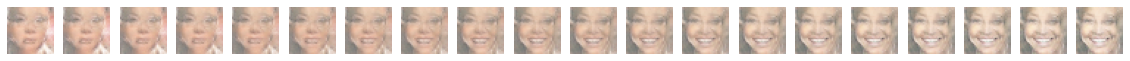

In [ ]:
# нейтральный человек ------> с улыбкой

fig, axs = plt.subplots(1, 20, figsize=(20,1))
for i, alpha in enumerate(np.linspace(0, 1, 20)):
        curr_vec = np.asarray([faces[2]]) * (1-alpha * 0.2) + smile * alpha * 0.2
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')

# добавил немного регуляризации, т.к. при вызове "стандартной" функции результаты получаются страшноватыми 

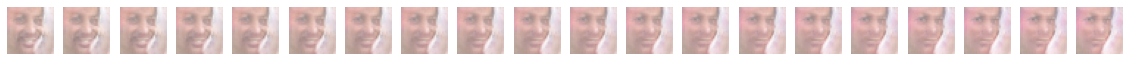

In [ ]:
# человек с улыбкой ------> нейтральный

fig, axs = plt.subplots(1, 20, figsize=(20,1))
for i, alpha in enumerate(np.linspace(0, 1, 20)):
        curr_vec = np.asarray([faces[5]]) * (1-alpha * 0.1) + neutral * alpha * 0.1
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')